# Importing Necessary Libraries

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNetV2
from keras import Model
from keras.layers.experimental import preprocessing
from keras.layers import Dense, Flatten, Dropout, BatchNormalization

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')

In [ ]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

### Create helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

# Data Collection and Transforming Data

In [ ]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [ ]:
# Walk through each directory
dataset = "/kaggle/input/agricultural-pests-image-dataset"
walk_through_dir(dataset)

There are 12 directories and 0 images in '/kaggle/input/agricultural-pests-image-dataset'.
There are 0 directories and 416 images in '/kaggle/input/agricultural-pests-image-dataset/beetle'.
There are 0 directories and 485 images in '/kaggle/input/agricultural-pests-image-dataset/grasshopper'.
There are 0 directories and 323 images in '/kaggle/input/agricultural-pests-image-dataset/earthworms'.
There are 0 directories and 499 images in '/kaggle/input/agricultural-pests-image-dataset/ants'.
There are 0 directories and 466 images in '/kaggle/input/agricultural-pests-image-dataset/earwig'.
There are 0 directories and 500 images in '/kaggle/input/agricultural-pests-image-dataset/snail'.
There are 0 directories and 434 images in '/kaggle/input/agricultural-pests-image-dataset/catterpillar'.
There are 0 directories and 485 images in '/kaggle/input/agricultural-pests-image-dataset/weevil'.
There are 0 directories and 500 images in '/kaggle/input/agricultural-pests-image-dataset/bees'.
There ar

# Placing data into a Dataframe
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The first column <b>filepaths</b> contains the file path location of each individual images. The second column <b>labels</b>, on the other hand, contains the class label of the corresponding image from the file path</p>

In [ ]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [ ]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/kaggle/input/grape-disease-dataset-original").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

## Distribution of images in each class

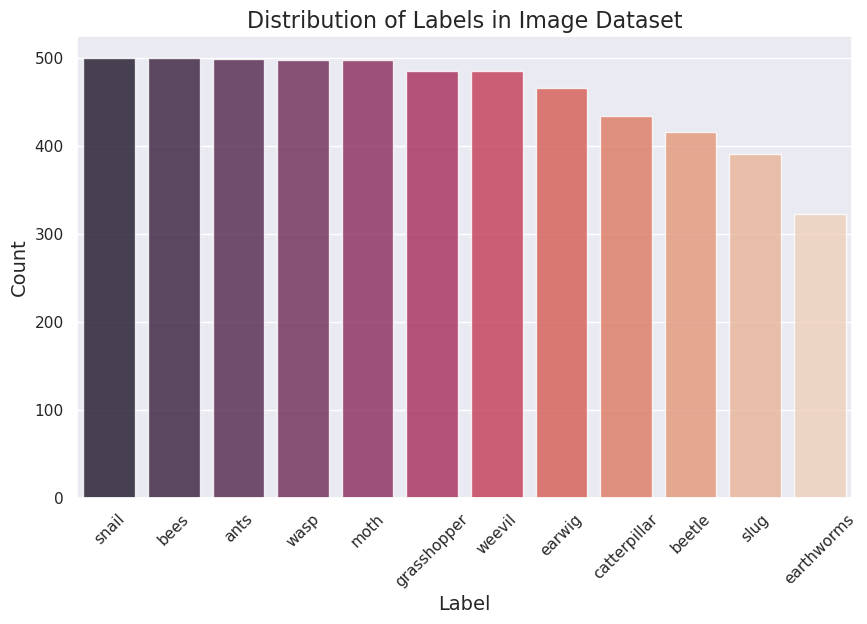

In [ ]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()


# Visualizing images from the dataset

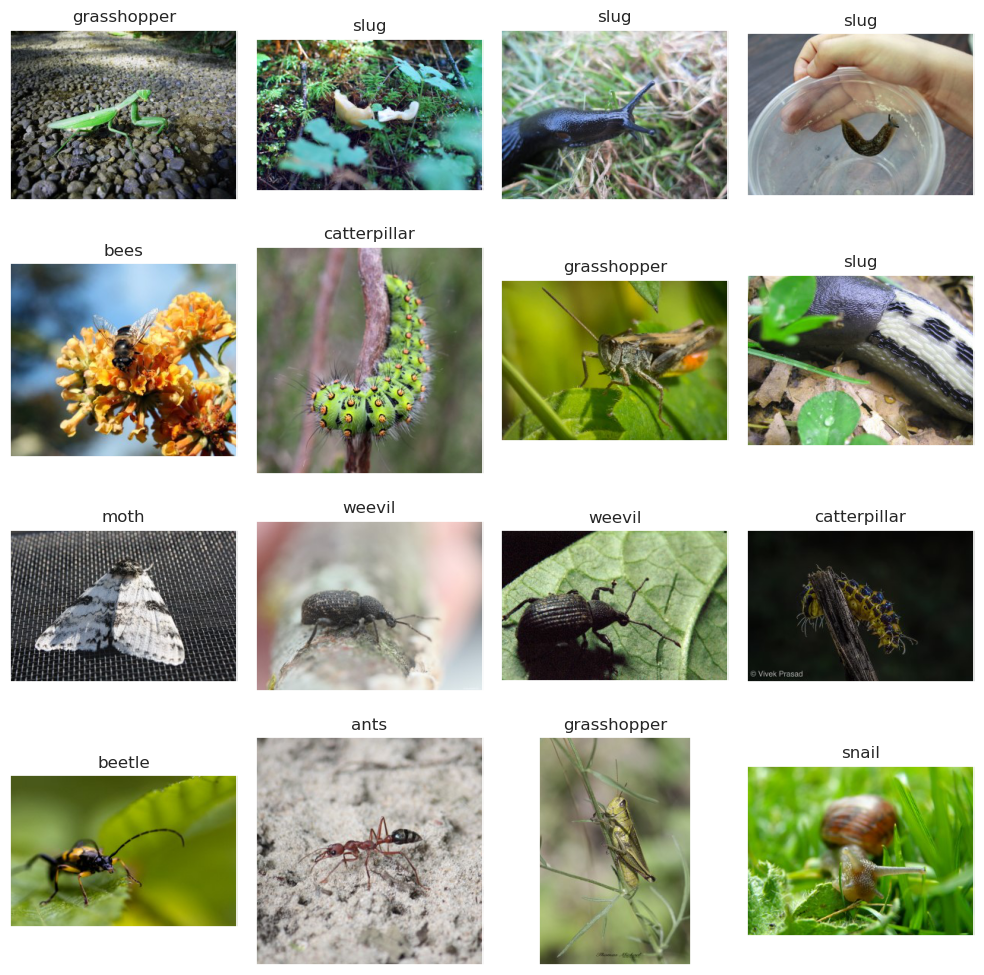

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Data Preprocessing
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing.

The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data.

Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3516 validated image filenames belonging to 12 classes.
Found 879 validated image filenames belonging to 12 classes.
Found 1099 validated image filenames belonging to 12 classes.


In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

# Training the model
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called EfficientNetV2L. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

<p style="font-size:15px">
  <strong>Batch size</strong>: 32<br>
  <strong>Epochs</strong>: 100<br>
  <strong>Input Shape</strong>: (224, 224, 3)<br>
  <strong>Output layer</strong>: 12
</p>




In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

473176280/473176280 [==============================] - 17s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "pests_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 5 epochs in a row, stop training

# Training the CNN model

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

# Add new classification layers
x = Flatten()(pretrained_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(12, activation='softmax')(x) # 12 classes

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "pests_cats_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/pests_cats_classification/20240304-154051
Epoch 1/100


2024-03-04 15:41:19.475890: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 79s 393ms/step - loss: 3.2312 - accuracy: 0.0899 - val_loss: 2.4120 - val_accuracy: 0.2048
Epoch 2/100
110/110 [==============================] - 34s 306ms/step - loss: 3.0135 - accuracy: 0.1106 - val_loss: 2.2316 - val_accuracy: 0.2799
Epoch 3/100
110/110 [==============================] - 34s 307ms/step - loss: 2.8413 - accuracy: 0.1496 - val_loss: 2.0968 - val_accuracy: 0.3732
Epoch 4/100
110/110 [==============================] - 34s 306ms/step - loss: 2.6704 - accuracy: 0.1741 - val_loss: 1.9783 - val_accuracy: 0.4391
Epoch 5/100
110/110 [==============================] - 34s 311ms/step - loss: 2.5198 - accuracy: 0.2085 - val_loss: 1.8690 - val_accuracy: 0.4926
Epoch 6/100
110/110 [==============================] - 34s 305ms/step - loss: 2.4302 - accuracy: 0.2272 - val_loss: 1.7555 - val_accuracy: 0.5495
Epoch 7/100
110/110 [==============================] - 34s 305ms/step - loss: 2.2826 - accuracy: 0.2742 - val_loss: 1.6609 - val_accurac

# Model Evaluation
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3>
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>


<h3>Recall(R): </h3>
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>


<h3>F1 score(F1): </h3>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.39907
Test Accuracy: 88.44%


# Visualizing accuracy and loss plots

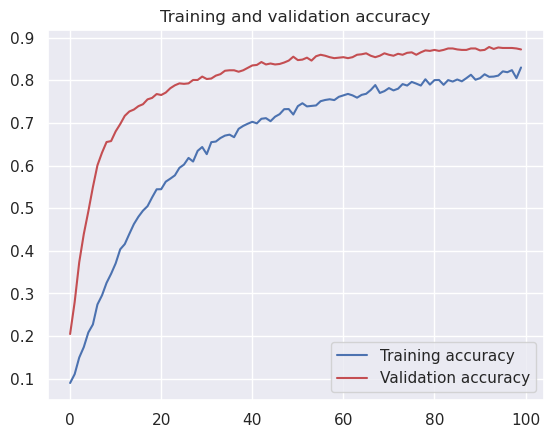

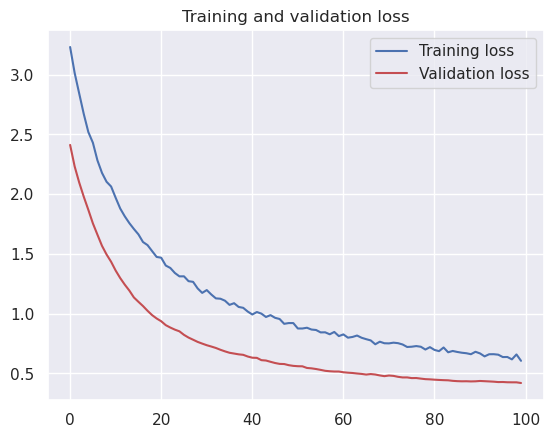

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# Making predictions on the Test Data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

35/35 [==============================] - 15s 216ms/step
The first 5 predictions: ['bees', 'grasshopper', 'moth', 'earthworms', 'wasp']


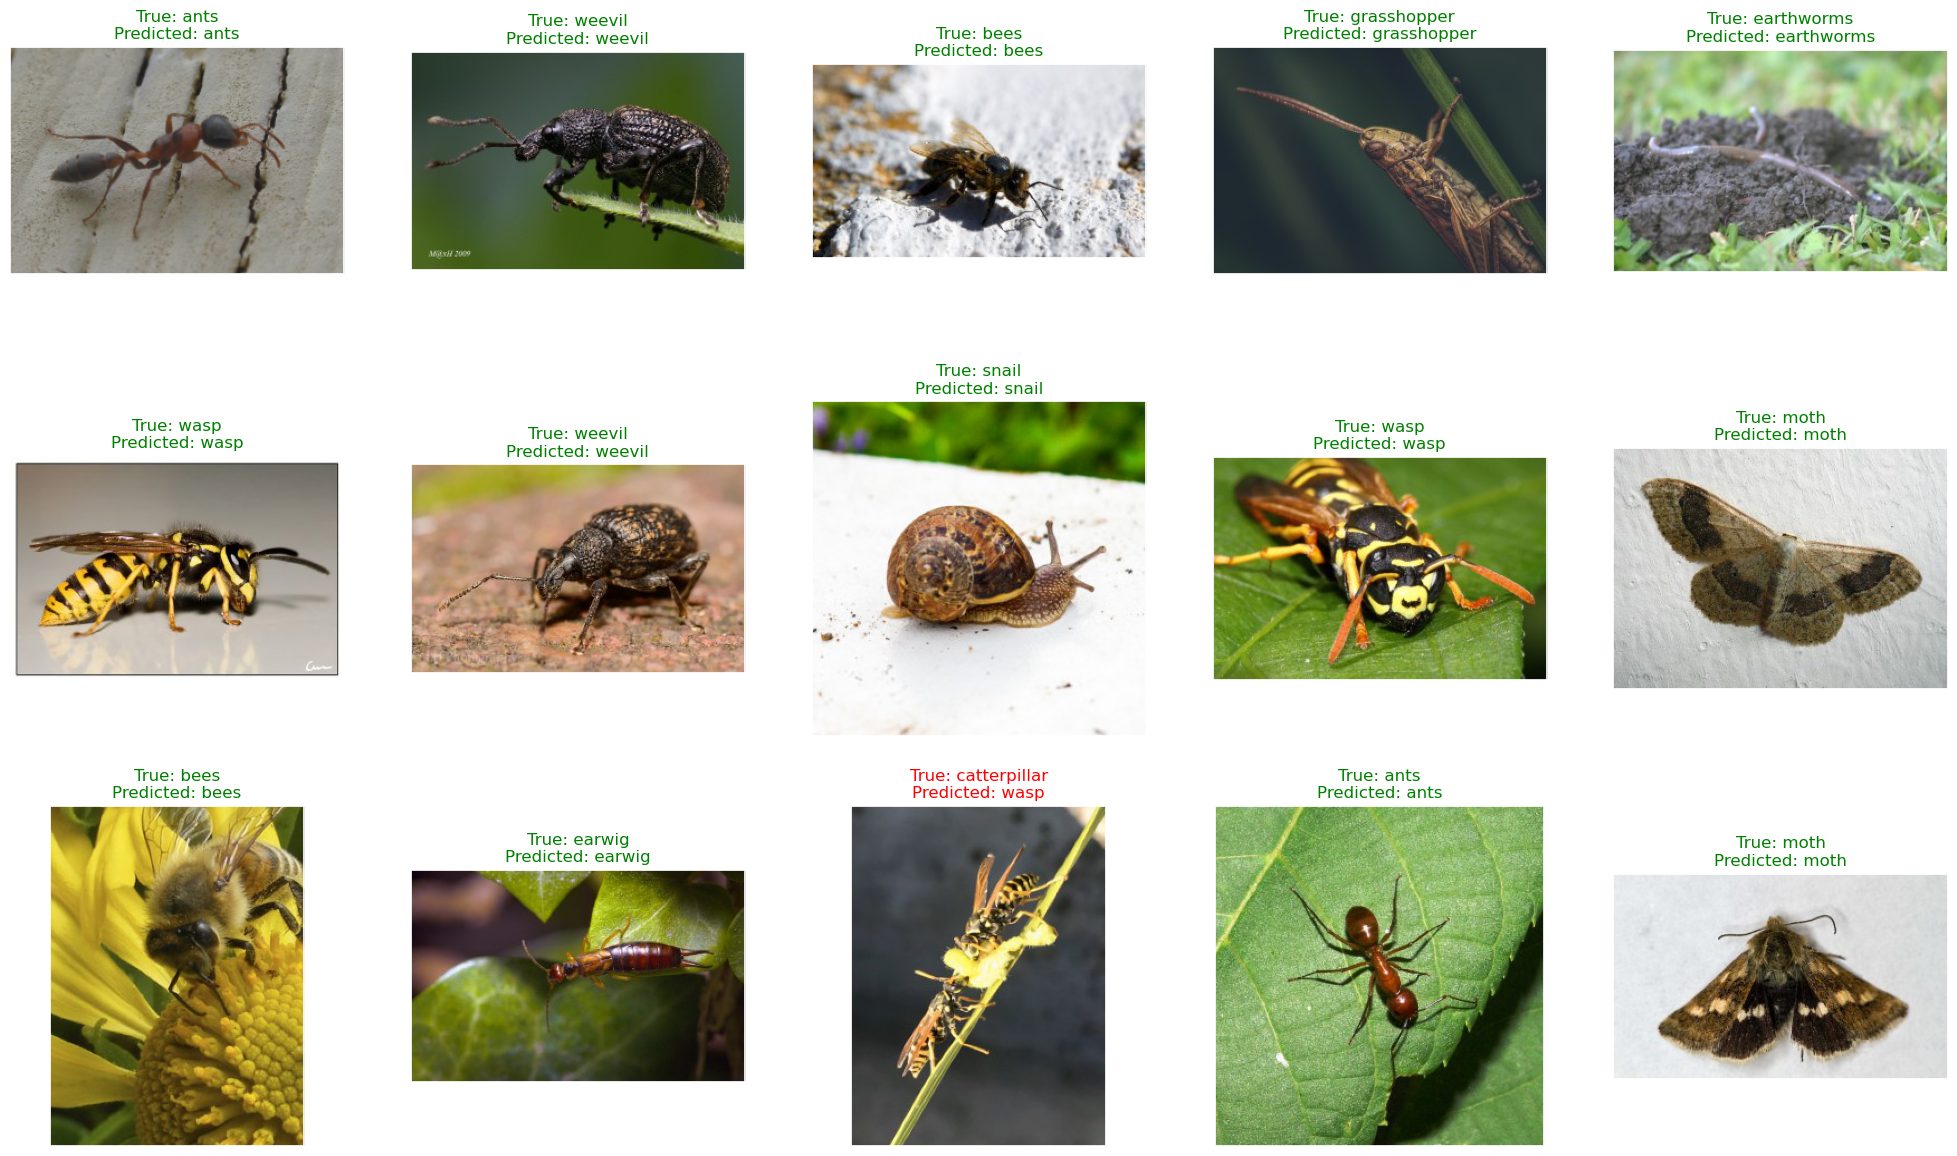

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Evaluation using Classification Report

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">A <b>classification report</b> is a summary of the key performance metrics for a classification model, including precision, recall, and F1-score, as well as the overall accuracy of the model. It provides a concise overview of the model's performance, typically broken down by class, and can be used to quickly assess the strengths and weaknesses of the model. The report is often presented as a table, with each row representing a class and columns showing various performance metrics. The report may also include other metrics such as support (the number of test samples belonging to a particular class), and the macro- and micro-averages of the performance metrics across all classes.</p>

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        ants       0.91      1.00      0.95        94
        bees       0.87      0.91      0.89        92
      beetle       0.91      0.71      0.80        94
catterpillar       0.64      0.81      0.72        85
  earthworms       0.90      0.79      0.84        67
      earwig       0.92      0.69      0.79        89
 grasshopper       0.94      0.91      0.93       105
        moth       0.87      0.91      0.89        99
        slug       0.90      0.92      0.91        76
       snail       1.00      1.00      1.00       102
        wasp       0.89      0.90      0.90       104
      weevil       0.91      1.00      0.95        92

    accuracy                           0.88      1099
   macro avg       0.89      0.88      0.88      1099
weighted avg       0.89      0.88      0.88      1099



# Confusion Matrix

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">A <b>confusion matrix</b> is a table that summarizes the number of correct and incorrect predictions made by a classification model on a set of test data. It is usually represented as a square matrix with rows and columns representing the predicted and true class labels, respectively. The entries of the matrix indicate the number of test samples that belong to a certain class, and how many of those were classified correctly or incorrectly by the model. A confusion matrix can provide a detailed breakdown of the performance of the model, including measures such as accuracy, precision, recall, and F1-score for each class. It can be used to identify specific areas where the model is making errors, and to diagnose problems with the model's predictions.</p>

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


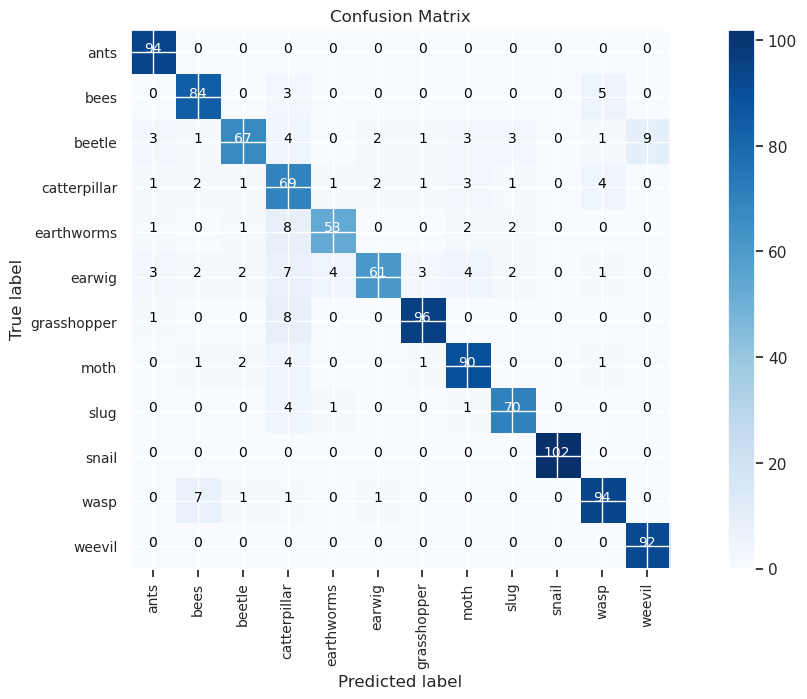

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">In image classification, both confusion matrix and classification report are important tools for evaluating the performance of the model, identifying areas for improvement, and making decisions about how to adjust the model's architecture or training parameters.</p>

# Model Interpretabilty using Grad-Cam Visualization

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"><b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction. It allows you to see which regions of the image the model focused on while making its prediction. Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.</p>

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

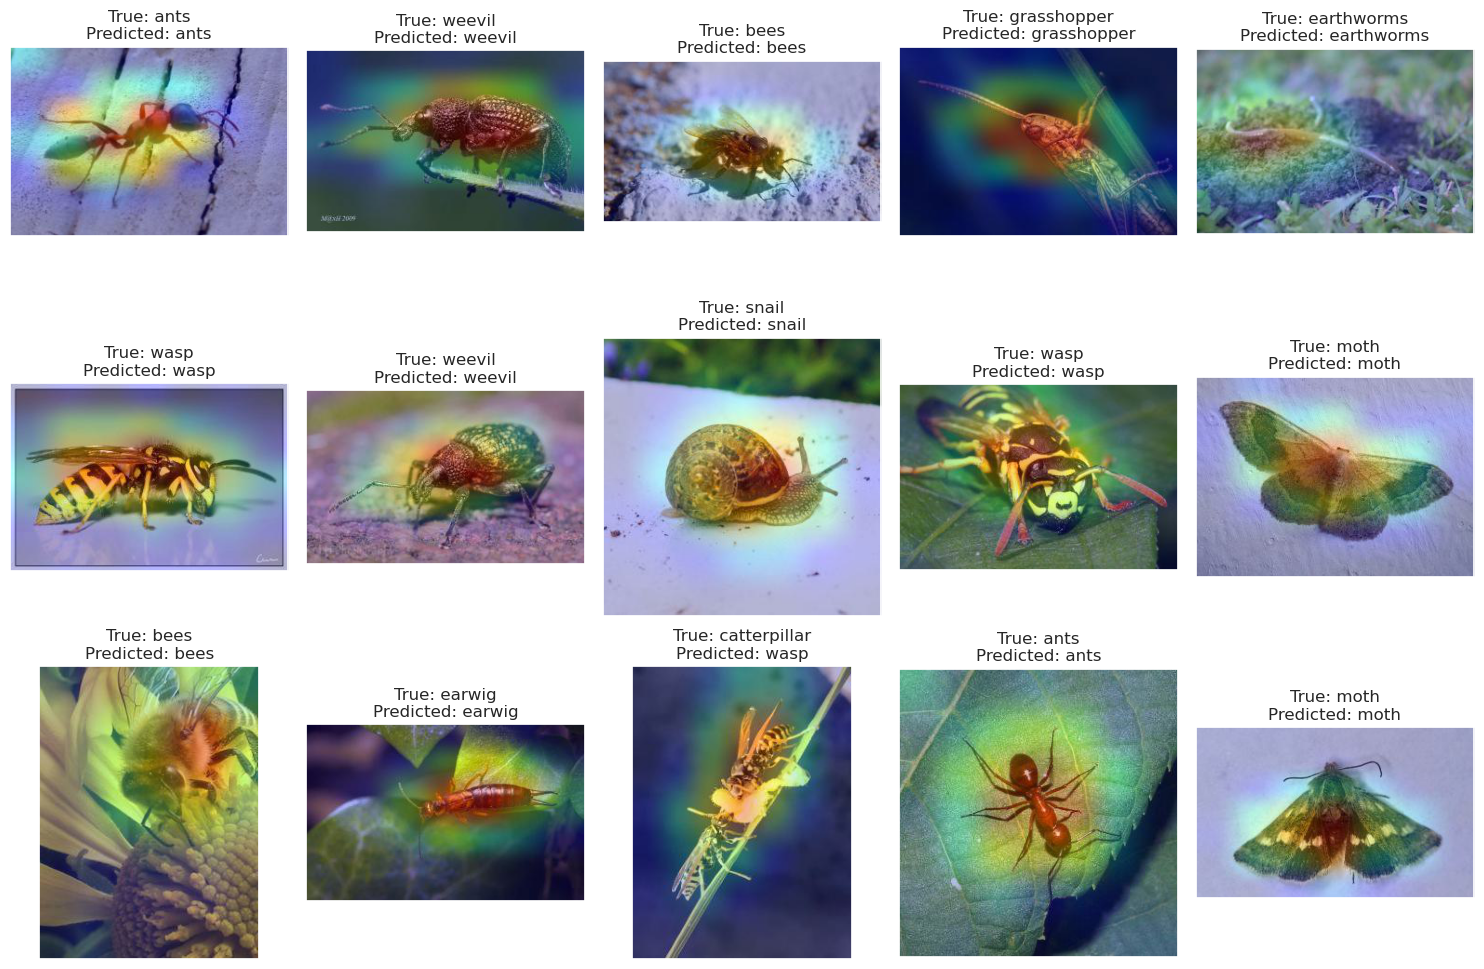

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()